In [51]:
# The dataset captures detailed transactional sales data across multiple countries, market segments and product lines, including financial metrics such as units sold, gross sales, discounts, COGS and profit.
# It spans the years 2013–2014 and is structured to support analysis of pricing strategies, profitability and regional performance trends.
import pandas as pd # Import the pandas library

# --- 1. Import dataset ---
f_df = pd.read_csv("Financials.csv")

In [52]:
# --- 2. Remove "$" signs, commas and convert numeric columns ---
numeric_columns = [
    "Units Sold", "Manufacturing Price", "Sale Price", "Gross Sales",
    "Discounts", "Sales", "COGS", "Profit"
]

In [53]:
# Loop through each column in the list of numeric columns
# Standardize column names to avoid KeyErrors due to inconsistencies (e.g., whitespace, casing)
f_df.columns = f_df.columns.str.strip().str.title()

# Update numeric_columns list to reflect the new casing of DataFrame columns
numeric_columns = [col.title() for col in numeric_columns]

for column_name_from_list in numeric_columns:
    # Standardize the column name from the list to match the DataFrame's title-cased columns
    actual_column_name = column_name_from_list.strip().title()

    f_df[actual_column_name] = (
        f_df[actual_column_name]
        .astype(str) # Ensure all values are treated as strings for uniform processing
        .str.replace(r"[\$,]", "", regex=True) # Remove dollar signs and commas using regex
        .str.strip() # Remove leading/trailing whitespace
        .replace({"-": None, "": None}) # Replace dashes and empty strings with None (missing values)
    )

    f_df[actual_column_name] = pd.to_numeric(f_df[actual_column_name], errors="coerce") # - 'errors="coerce"' ensures that any non-convertible values become NaN

In [54]:
# --- 3. Handle missing values in Discount Band ---
f_df["Discount Band"] = f_df["Discount Band"].replace("None", pd.NA)

In [55]:
# --- 4. Convert Date → datetime, extract Month + Year ---
f_df["Date"] = pd.to_datetime(f_df["Date"], errors="coerce") # Convert the 'Date' column from string format to pandas datetime format whilst 'errors="coerce"' ensures that any invalid or unparseable dates are converted to NaT (missing datetime)
f_df["Month"] = f_df["Date"].dt.month_name() # Extract the full month name from the parsed 'Date' column
f_df["Year"] = f_df["Date"].dt.year # Extract the year from the parsed 'Date' column

In [56]:
# --- 5. Standardise categories (strip whitespace, title case) ---
categorical_columns = ["Segment", "Country", "Product", "Discount Band", "Month Name"] # Define the list of categorical columns to clean
for col in categorical_columns: # Loop through each categorical column to clean text formatting
    f_df[col] = f_df[col].astype(str).str.strip().str.title() # Ensure all values are treated as strings, remove leading and trailing whitespace and convert to title case

# --- 6. Check for duplicates ---
duplicates = f_df.duplicated().sum() # Count the number of duplicate rows in the dataset
f_df = f_df.drop_duplicates() # Drop all exact duplicate rows from the dataset
print(f"Removed {duplicates} duplicate rows.") # Print the number of duplicates removed for audit and transparency

Removed 0 duplicate rows.


In [57]:
# --- 7. Metadata summary ---
# Numeric summary
# Create a title-cased version of numeric_columns to match DataFrame's column names
processed_numeric_columns = [col.title() for col in numeric_columns]
numeric_summary = f_df[processed_numeric_columns].describe()

# Categorical summary
categorical_summary = {col: f_df[col].value_counts() for col in categorical_columns}

In [58]:
# --- 8. Data dictionary ---
data_dictionary = {
    "Segment": "Market segment (Government, Midmarket, Enterprise, Channel Partners, Small Business)",
    "Country": "Country where the transaction occurred",
    "Product": "Product sold (Carretera, Montana, Paseo, Velo, VTT, Amarilla)",
    "Discount Band": "Discount category applied (None, Low, etc.)",
    "Units Sold": "Number of units sold",
    "Manufacturing Price": "Cost to manufacture one unit",
    "Sale Price": "Price at which product was sold per unit",
    "Gross Sales": "Total sales before discounts (Units Sold × Sale Price)",
    "Discounts": "Total discount applied",
    "Sales": "Net sales after discounts",
    "COGS": "Cost of goods sold (Units Sold × Manufacturing Price)",
    "Profit": "Net profit (Sales – COGS)",
    "Date": "Transaction date",
    "Month Number": "Month of transaction (1–12)",
    "Month Name": "Month name (January–December)",
    "Year": "Year of transaction",
    "Month": "Extracted month name from Date"
}

# --- 9. Outputs ---
print("\n--- Numeric Summary ---") # Print the numeric summary statistics for all numeric columns
print(numeric_summary)

print("\n--- Categorical Summary ---") # Print the frequency distribution for each categorical column
for col, summary in categorical_summary.items():
    print(f"\n{col}:\n{summary}")

print("\n--- Data Dictionary ---") # Print the data dictionary in a readable format
for k, v in data_dictionary.items():
    print(f"{k}: {v}")


--- Numeric Summary ---
        Units Sold  Manufacturing Price  Sale Price   Gross Sales  \
count   700.000000           700.000000  700.000000  7.000000e+02   
mean   1608.294286            96.477143  118.428571  1.827594e+05   
std     867.427859           108.602612  136.775515  2.542623e+05   
min     200.000000             3.000000    7.000000  1.799000e+03   
25%     905.000000             5.000000   12.000000  1.739175e+04   
50%    1542.500000            10.000000   20.000000  3.798000e+04   
75%    2229.125000           250.000000  300.000000  2.790250e+05   
max    4492.500000           260.000000  350.000000  1.207500e+06   

           Discounts         Sales           Cogs         Profit  
count     647.000000  7.000000e+02     700.000000     637.000000  
mean    14227.586198  1.696091e+05  145475.211429   27741.010267  
std     23562.833079  2.367263e+05  203865.506118   43059.332905  
min        18.410000  1.655080e+03     918.000000     285.600000  
25%      1061.0000

# **PHASE 2 EDA**

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
#Dataset Overview
f_df.info()
f_df.describe()
f_df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Segment              700 non-null    object        
 1   Country              700 non-null    object        
 2   Product              700 non-null    object        
 3   Discount Band        700 non-null    object        
 4   Units Sold           700 non-null    float64       
 5   Manufacturing Price  700 non-null    float64       
 6   Sale Price           700 non-null    float64       
 7   Gross Sales          700 non-null    float64       
 8   Discounts            647 non-null    float64       
 9   Sales                700 non-null    float64       
 10  Cogs                 700 non-null    float64       
 11  Profit               637 non-null    float64       
 12  Date                 700 non-null    datetime64[ns]
 13  Month Number         700 non-null  

,Segment,Country,Product,Discount Band,Units Sold,Manufacturing Price,Sale Price,Gross Sales,Discounts,Sales,Cogs,Profit,Date,Month Number,Month Name,Year,Month
0,Government,Canada,Carretera,None,1618.5,3.0,20.0,32370.0,NaN,32370.0,16185.0,16185.0,2014-01-01,1,January,2014,January


# 1.  Outlier Detection (Boxplots)

To identify extreme values in numeric features like Profit, Units Sold, Sale Price, and COGS that could distort the model.

# **Profit Outlier Analysis**

Profit has many high value outliers, showing that only a few transactions generate very large profits.

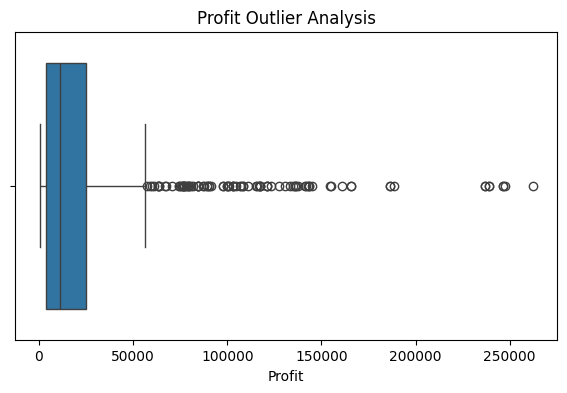

In [61]:
plt.figure(figsize=(7,4))
sns.boxplot(x=f_df['Profit'])
plt.title("Profit Outlier Analysis")
plt.show()

# **Units Sold**

Units Sold has several high value outliers, meaning a few products sell much more than the rest.

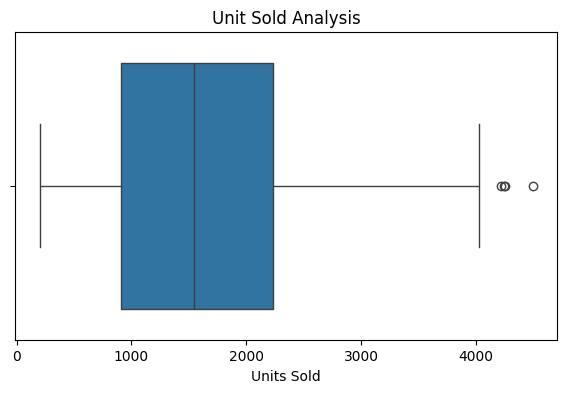

In [62]:
plt.figure(figsize=(7,4))
sns.boxplot(x=f_df['Units Sold'])
plt.title("Unit Sold Analysis")
plt.show()

## **Sales Price Analysis**

Sale Price has a wide but stable distribution with no extreme outliers, showing consistent product pricing variations.

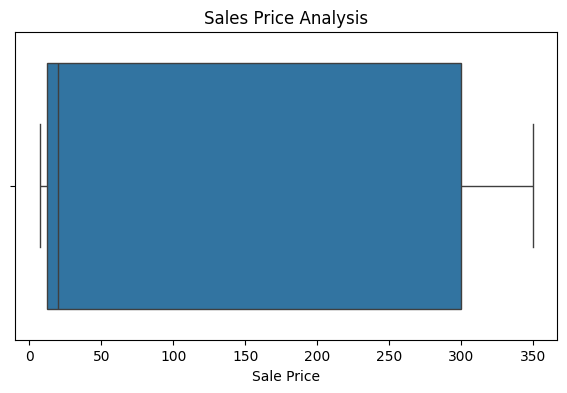

In [63]:
plt.figure(figsize=(7,4))
sns.boxplot(x=f_df['Sale Price'])
plt.title("Sales Price Analysis")
plt.show()

# **COGS Analysis**

COGS contains large outliers, reflecting costly high-value products in the dataset.

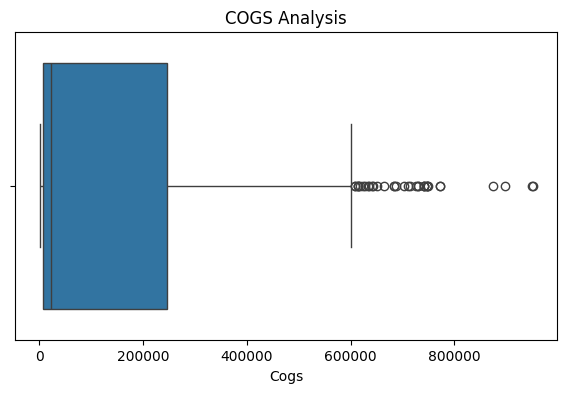

In [65]:
plt.figure(figsize=(7,4))
sns.boxplot(x=f_df['Cogs'])
plt.title("COGS Analysis")
plt.show()

#2. Distribution Plots (Histogram + KDE)

To understand the shape of each numeric feature especially Profit.
Histograms and KDE show the distribution shape of numeric variables, helping us understand skewness and variability before modelling.

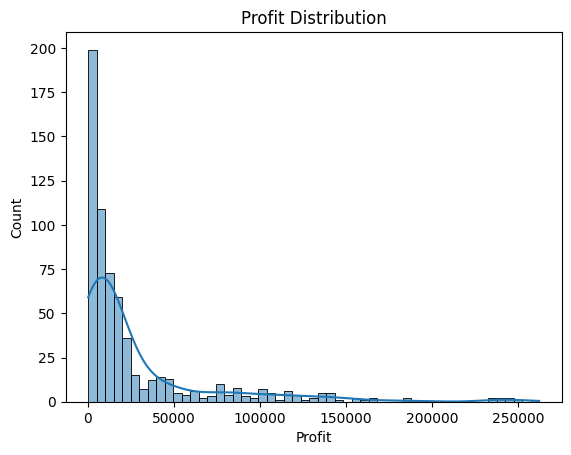

In [66]:
sns.histplot(f_df['Profit'], kde=True)
plt.title("Profit Distribution")
plt.show()

The Profit histogram with KDE shows a positively skewed distribution.
Most product entries generate relatively low profit, while a small number of entries produce extremely high profit values. This creates a long right tail. Such skewness is common in financial datasets and indicates that a few high-performing transactions contribute heavily to total profit.

This pattern also highlights the presence of outliers, which can influence regression performance and increase prediction errors. Understanding this distribution is important for preparing the data and selecting appropriate modelling techniques.

#3. Scatter Relationships

Scatter plots allow us to visually confirm how strongly each feature influences Profit, guiding our feature selection.

1. **Higher selling prices strongly drive higher profit levels.**

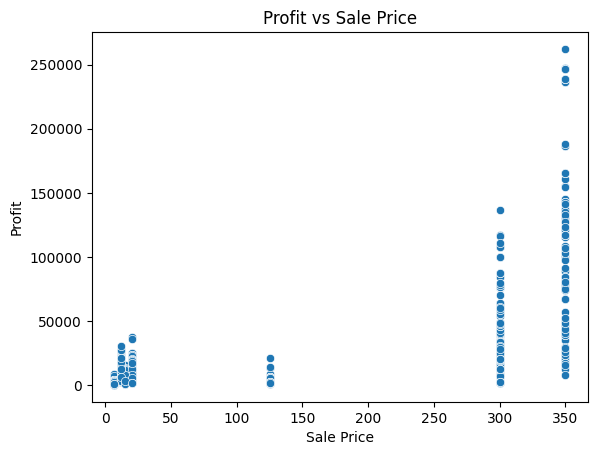

In [67]:
sns.scatterplot(data=f_df, x='Sale Price', y='Profit')
plt.title("Profit vs Sale Price")
plt.show()

2. **Selling more units contributes directly to higher total profit.**

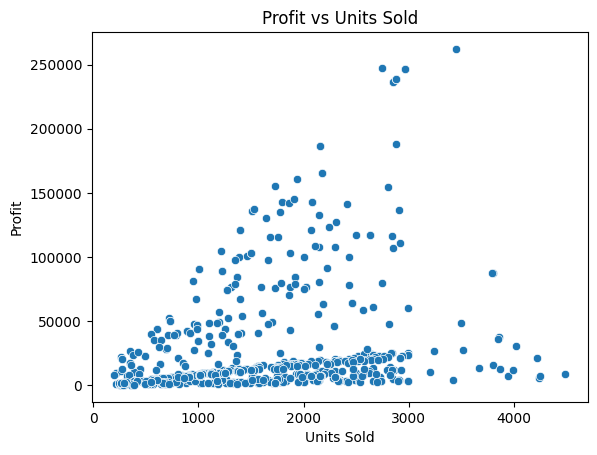

In [68]:
sns.scatterplot(data=f_df, x='Units Sold', y='Profit')
plt.title("Profit vs Units Sold")
plt.show()

3. **Higher value products have higher COGS but also generate higher profit overall.**

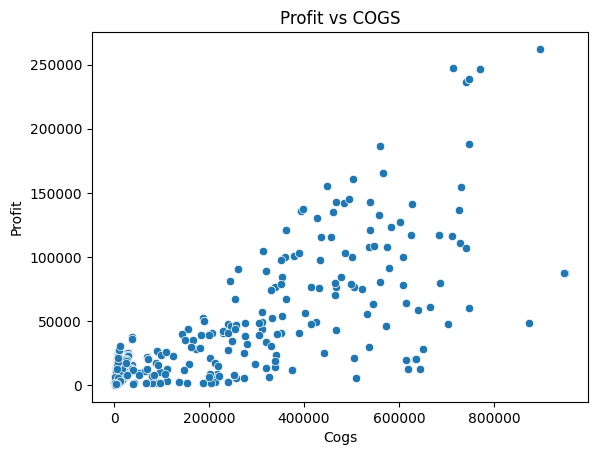

In [70]:
sns.scatterplot(data=f_df, x='Cogs', y='Profit')
plt.title("Profit vs COGS")
plt.show()

#4. Correlation Heatmap

The correlation heatmap quantifies the strength of relationships between features and Profit, and helps avoid multicollinearity in the model.

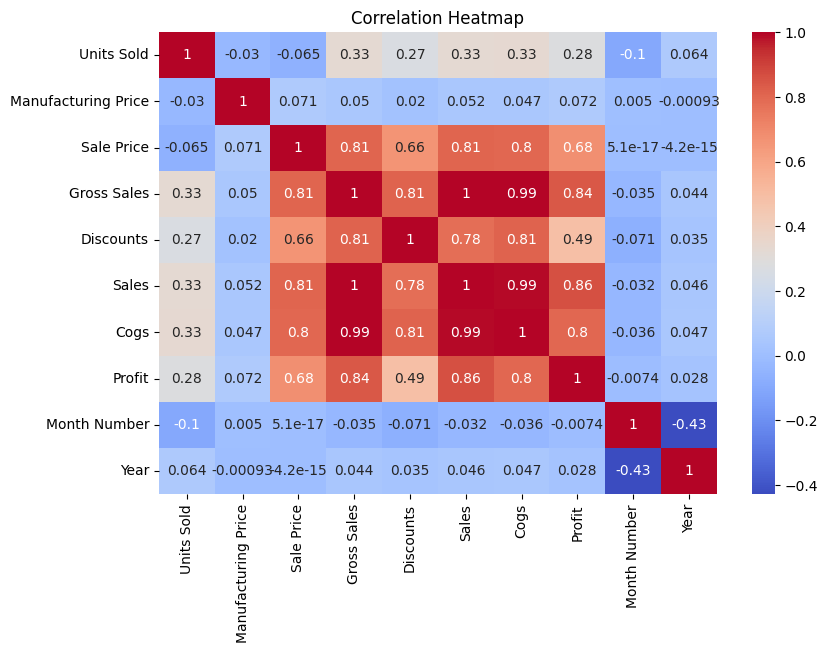

In [73]:
numeric_cols = [
    'Units Sold', 'Manufacturing Price', 'Sale Price', 'Gross Sales',
    'Discounts', 'Sales', 'Cogs', 'Profit', 'Month Number', 'Year'
]
f_df[numeric_cols].corr()

plt.figure(figsize=(9,6))
sns.heatmap(f_df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


* Profit is strongly correlated with Gross Sales and Sale Price, meaning higher sales amount and higher price directly increase profit.

* Units Sold has a moderate positive correlation, showing that selling more units generally leads to higher profit.

* COGS has a negative correlation with Profit, because higher production costs reduce profitability.

* Many variables (Gross Sales, Sales, Discounts, COGS) are highly correlated with each other, indicating multicollinearity common in financial data.

* Month and Year show almost no correlation, meaning time does not strongly influence profit in this dataset.

In [ ]:
# Save the cleaned DataFrame to a new CSV file
f_df.to_csv("Cleaned_Financials.csv", index=False)